In this notebook I am going to implement new approach for the title category because there are a lot of different car titles (models) in the data set 
the models don't get enough information only based on the category so in this model train notebook i am going to add some aggregate features per category  

In [1]:
from scipy.stats import norm
from itertools import product
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import joblib

In [122]:
process_df = pd.read_csv("C:\\Users\\moran\\personal_projects\\vfm_car_finder\\VFM_car_finder\\processed_data.csv")
process_df.shape

(40556, 24)

remove outliers based on aggregate price

In [123]:
def drop_price_outliers_by_title(df, price_col='price', title_col='title', ratio_thresh=10, max_iter=5, verbose=True):
    df = df.copy()
    initial_len = len(df)

    for i in range(max_iter):
        prev_len = len(df)
        
        # Step 1: Calculate average price per title
        avg_prices = df.groupby(title_col)[price_col].mean().rename('avg_price_by_title')
        df = df.merge(avg_prices, on=title_col, how='left')
        
        # Step 2: Compute price ratio
        ratio = df['avg_price_by_title'] / df[price_col]

        # Step 3: Filter entries within threshold
        mask = (ratio < ratio_thresh) & (ratio > (1 / ratio_thresh))
        df = df[mask].copy()

        # Step 4: Stop condition
        if verbose:
            print(f"Iteration {i+1}: {prev_len - len(df)} rows dropped")
        if len(df) == prev_len:
            break

        # Step 5: Drop avg_price_by_title before next iteration
        df.drop(columns='avg_price_by_title', inplace=True)

    if verbose:
        print(f"\nTotal dropped: {initial_len - len(df)} entries")
    return df


In [124]:
process_df = drop_price_outliers_by_title(process_df)
process_df.drop('avg_price_by_title', axis=1, inplace=True)
process_df.shape

Iteration 1: 676 rows dropped
Iteration 2: 9 rows dropped
Iteration 3: 1 rows dropped
Iteration 4: 0 rows dropped

Total dropped: 686 entries


(39870, 24)

remove titles that has less than 50 observation in the data set because the prediction is to in accurate for production model, so it better not to 
recommend on a car that the her prediction uncertainty is large

In [125]:
# Count number of listings per title
titles_count = process_df.groupby('title').size()

# Keep only titles with >= 50 listings
valid_titles = titles_count[titles_count >= 50].index

# Filter the original DataFrame
process_df = process_df[process_df['title'].isin(valid_titles)]
print(process_df.shape)

(33524, 24)


check the correlation of the new features

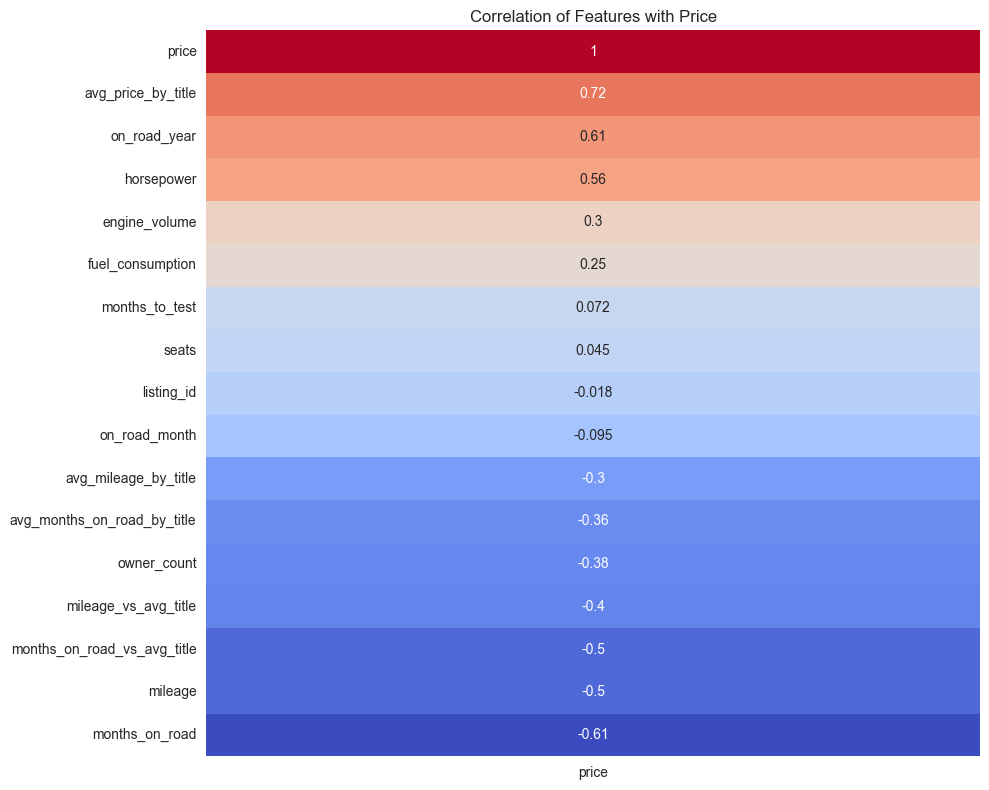

In [126]:
# Make a copy of the DataFrame
df = process_df.copy()

# Step 1: Group by 'title' and calculate averages
title_aggregates = df.groupby('title').agg({
    'price': 'mean',
    'mileage': 'mean',
    'months_on_road': 'mean'
}).rename(columns={
    'price': 'avg_price_by_title',
    'mileage': 'avg_mileage_by_title',
    'months_on_road': 'avg_months_on_road_by_title'
})

# Step 2: Merge the aggregates back into the copied df
df = df.merge(title_aggregates, on='title', how='left')

# Step 3: Create ratio features
df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
df['months_on_road_vs_avg_title'] = df['months_on_road'] / df['avg_months_on_road_by_title']

# Step 4: Correlation map for numeric columns
numeric_cols = df.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()

# Step 5: Extract correlations with 'price', sort and plot
price_corr = correlation_matrix['price'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(price_corr.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation of Features with Price')
plt.tight_layout()
plt.show()

in this part I am going to compare based on cross validation between catBoost and lightGBM

In [127]:
# Prepare data
boots_df_cat = process_df.copy()
boots_df_cat = boots_df_cat.reset_index(drop=True)
boots_df_cat['predicted_price'] = np.nan

kf = KFold(n_splits=20, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(boots_df_cat):
    train_df = boots_df_cat.iloc[train_idx].copy()
    test_df = boots_df_cat.iloc[test_idx].copy()

    # Aggregate by title
    title_agg = train_df.groupby('title').agg({
        'price': 'mean',
        'mileage': 'mean',
        'months_on_road': 'mean'
    }).rename(columns={
        'price': 'avg_price_by_title',
        'mileage': 'avg_mileage_by_title',
        'months_on_road': 'avg_months_on_road_by_title'
    })

    # Merge aggregates
    train_df = train_df.merge(title_agg, on='title', how='left')
    test_df = test_df.merge(title_agg, on='title', how='left')

    # Derived features
    for df in [train_df, test_df]:
        df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
        df['months_on_road_vs_avg_title'] = df['months_on_road'] / df['avg_months_on_road_by_title']

    # Feature selection
    exclude = ['listing_id', 'title', 'price', 'predicted_price', 'url', 'scrape_date', 'upload_date']
    features = [col for col in train_df.columns if col not in exclude]

    x_train = train_df[features].copy()
    y_train = train_df['price']
    x_test = test_df[features].copy()
    y_test = test_df['price']

    # Clean NaNs and Infs
    x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Detect feature types
    cat_features = x_train.select_dtypes(include='category').columns.tolist()
    num_features = x_train.select_dtypes(include='number').columns.tolist()

    # Impute missing
    preprocessor = ColumnTransformer([
        ('num', SimpleImputer(strategy='mean'), num_features),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ])
    x_train_imp = pd.DataFrame(preprocessor.fit_transform(x_train), columns=num_features + cat_features, index=x_train.index)
    x_test_imp = pd.DataFrame(preprocessor.transform(x_test), columns=num_features + cat_features, index=x_test.index)

    # Ensure correct types
    for col in cat_features:
        x_train_imp[col] = x_train_imp[col].astype('category')
        x_test_imp[col] = x_test_imp[col].astype('category')

    # Train model
    model = CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=1,
        border_count=90,
        verbose=0,
        random_seed=42
    )
    model.fit(x_train_imp, y_train, cat_features=cat_features)

    # Predict
    preds = model.predict(x_test_imp)
    boots_df_cat.loc[test_idx, 'predicted_price'] = preds

# Final evaluation
y_true = boots_df_cat['price']
y_pred = boots_df_cat['predicted_price']
mae = mean_absolute_error(y_true, y_pred)
mae_pct = np.mean(np.abs(y_pred - y_true) / y_true) * 100
r2 = r2_score(y_true, y_pred)
error_pct = np.abs((y_pred - y_true) / y_true)

# Report
print(f"MAE: {mae:.2f}")
print(f"MAE (% of price): {mae_pct:.2f}%")
print(f"R² Score: {r2:.4f}")
print("Error as % of price (quantiles):")
print(error_pct.quantile([0.25, 0.5, 0.75, 0.95]))


MAE: 6716.73
MAE (% of price): 11.88%
R² Score: 0.9724
Error as % of price (quantiles):
0.25    0.032625
0.50    0.072391
0.75    0.139674
0.95    0.358690
dtype: float64


In [128]:
# Copy the dataframe
boots_df_gbm = process_df.copy()
boots_df_gbm = boots_df_gbm.reset_index(drop=True)
kf = KFold(n_splits=20, shuffle=True, random_state=42)

# Placeholder for predictions
boots_df_gbm['predicted_price'] = np.nan

# K-Fold Loop
for train_idx, test_idx in kf.split(boots_df_gbm):
    train_df = boots_df_gbm.iloc[train_idx].copy()
    test_df = boots_df_gbm.iloc[test_idx].copy()

    # Create aggregates
    title_agg = train_df.groupby('title').agg({
        'price': 'mean',
        'mileage': 'mean',
        'months_on_road': 'mean'
    }).rename(columns={
        'price': 'avg_price_by_title',
        'mileage': 'avg_mileage_by_title',
        'months_on_road': 'avg_months_on_road_by_title'
    })

    # Merge aggregates
    train_df = train_df.merge(title_agg, on='title', how='left')
    test_df = test_df.merge(title_agg, on='title', how='left')

    for df in [train_df, test_df]:
        df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
        df['months_on_road_vs_avg_title'] = df['months_on_road'] / df['avg_months_on_road_by_title']

    # Feature selection
    exclude = ['listing_id', 'title', 'price', 'predicted_price', 'url', 'scrape_date', 'upload_date']
    features = [col for col in train_df.columns if col not in exclude]
    x_train, y_train = train_df[features], train_df['price']
    x_test = test_df[features]

    # Replace infs and NaNs
    x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    for col in x_train.columns:
        if x_train[col].dtype == 'object':
            x_train[col] = pd.to_numeric(x_train[col], errors='coerce')
            x_test[col] = pd.to_numeric(x_test[col], errors='coerce')

    cat_features = x_train.select_dtypes(include='category').columns.tolist()
    num_features = x_train.select_dtypes(include='number').columns.tolist()

    # Impute
    preprocessor = ColumnTransformer([
        ('num', SimpleImputer(strategy='mean'), num_features),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ])
    x_train_array = preprocessor.fit_transform(x_train)
    x_test_array = preprocessor.transform(x_test)

    cols_out = preprocessor.get_feature_names_out()
    x_train_imp = pd.DataFrame(x_train_array, columns=cols_out, index=x_train.index)
    x_test_imp = pd.DataFrame(x_test_array, columns=cols_out, index=x_test.index)

    # Fix dtypes
    for col in cols_out:
        if col.startswith('num__'):
            x_train_imp[col] = x_train_imp[col].astype(float)
            x_test_imp[col] = x_test_imp[col].astype(float)

    cat_cols_imp = [col for col in cols_out if col.startswith('cat__')]
    enc = OrdinalEncoder()
    x_train_imp[cat_cols_imp] = enc.fit_transform(x_train_imp[cat_cols_imp])
    x_test_imp[cat_cols_imp] = enc.transform(x_test_imp[cat_cols_imp])

    # Train
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=10,
        reg_lambda=1,
        random_state=42,
        verbosity=-1
    )
    model.fit(x_train_imp, y_train)

    preds = model.predict(x_test_imp)
    boots_df_gbm.loc[test_idx, 'predicted_price'] = preds

# Final evaluation
y_true = boots_df_gbm['price']
y_pred = boots_df_gbm['predicted_price']
mae = mean_absolute_error(y_true, y_pred)
mae_pct = np.mean(np.abs(y_pred - y_true) / y_true) * 100
r2 = r2_score(y_true, y_pred)
error_pct = np.abs((y_pred - y_true) / y_true)

# Report
print(f"MAE: {mae:.2f}")
print(f"MAE (% of price): {mae_pct:.2f}%")
print(f"R² Score: {r2:.4f}")
print("Error as % of price (quantiles):")
print(error_pct.quantile([0.25, 0.5, 0.75, 0.95]))


MAE: 6604.03
MAE (% of price): 11.50%
R² Score: 0.9716
Error as % of price (quantiles):
0.25    0.030639
0.50    0.069734
0.75    0.134904
0.95    0.349510
dtype: float64


compare between the models errors by category  

In [129]:
# Filter only rows with predictions
cat_df = boots_df_cat[boots_df_cat['predicted_price'].notna()].copy()
gbm_df = boots_df_gbm[boots_df_gbm['predicted_price'].notna()].copy()

# Rename predicted_price columns
cat_df = cat_df.rename(columns={'predicted_price': 'predicted_price_cat'})
gbm_df = gbm_df.rename(columns={'predicted_price': 'predicted_price_gbm'})

# Merge on a unique key, e.g., 'listing_id'
merged = pd.merge(cat_df[['listing_id', 'title', 'price', 'predicted_price_cat']],
                  gbm_df[['listing_id', 'predicted_price_gbm']],
                  on='listing_id',
                  how='inner')

# Compute error percentages
merged['error_pct_cat'] = 100 * np.abs(merged['predicted_price_cat'] - merged['price']) / merged['price']
merged['error_pct_gbm'] = 100 * np.abs(merged['predicted_price_gbm'] - merged['price']) / merged['price']

# Aggregate errors per title
title_comparison = merged.groupby('title').agg({
    'error_pct_cat': ['mean', 'median', 'std'],
    'error_pct_gbm': ['mean', 'median', 'std']
}).reset_index()

# Flatten column names
title_comparison.columns = ['title',
                            'cat_avg_error_pct', 'cat_median_error_pct', 'cat_std_error_pct',
                            'gbm_avg_error_pct', 'gbm_median_error_pct', 'gbm_std_error_pct']

# View result
title_comparison

,title,cat_avg_error_pct,cat_median_error_pct,cat_std_error_pct,gbm_avg_error_pct,gbm_median_error_pct,gbm_std_error_pct
0,אאודי A1,9.783052,9.162076,7.961832,10.079344,8.446111,7.843600
1,אאודי A3,13.586132,8.034035,20.358439,14.302442,7.867282,19.940537
2,אאודי A4,16.926155,7.906139,25.706610,18.042352,10.375858,21.867658
3,אאודי Q3,8.846109,6.558356,8.958182,8.273226,6.080055,9.498826
4,אאודי Q5,12.229437,8.201053,19.924848,12.452859,8.203275,21.625038
...,...,...,...,...,...,...,...
173,שברולט טרייל בלייזר,11.961890,5.006826,19.000538,15.542232,4.576467,31.744296
174,שברולט מאליבו,28.086960,18.053450,33.932029,25.612343,14.600684,31.057465
175,שברולט סוניק,22.981662,17.385652,33.655902,21.494541,15.592218,32.243690
176,שברולט ספארק,14.207129,9.963748,15.675715,11.703782,8.261839,12.277731


In [130]:
def remove_outliers_iqr(df, col='error_pct'):
    cleaned_groups = []
    for title, group in df.groupby('title'):
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr
        filtered = group[(group[col] >= lower) & (group[col] <= upper)]
        cleaned_groups.append(filtered)
    return pd.concat(cleaned_groups)

def compute_title_errors(df, pred_col, suffix):
    df = df[df[pred_col].notna()].copy()
    df[f'error_pct_{suffix}'] = 100 * np.abs(df[pred_col] - df['price']) / df['price']
    df = remove_outliers_iqr(df, col=f'error_pct_{suffix}')
    grouped = (
        df.groupby('title')[f'error_pct_{suffix}']
        .agg(
            **{f'avg_error_pct_{suffix}': 'mean',
               f'median_error_pct_{suffix}': 'median',
               f'std_error_pct_{suffix}': 'std'}
        )
        .reset_index()
    )
    return grouped

# Compute title errors for each model
errors_cat = compute_title_errors(boots_df_cat, 'predicted_price', 'cat')
errors_gbm = compute_title_errors(boots_df_gbm, 'predicted_price', 'gbm')

# Merge into a comparison DataFrame
title_comparison = pd.merge(errors_cat, errors_gbm, on='title', how='inner')

# Display result
title_comparison

,title,avg_error_pct_cat,median_error_pct_cat,std_error_pct_cat,avg_error_pct_gbm,median_error_pct_gbm,std_error_pct_gbm
0,אאודי A1,9.783052,9.162076,7.961832,10.079344,8.446111,7.843600
1,אאודי A3,10.343171,7.137549,9.665803,11.133749,7.376602,11.447629
2,אאודי A4,11.639267,7.372371,11.835187,13.387925,9.535258,11.545567
3,אאודי Q3,8.168948,6.354339,6.882960,7.068501,5.987779,5.894895
4,אאודי Q5,10.317444,8.029296,8.580908,10.392570,8.143454,8.846565
...,...,...,...,...,...,...,...
173,שברולט טרייל בלייזר,8.217835,4.526556,9.029214,6.778636,4.004581,6.566170
174,שברולט מאליבו,24.614103,17.456128,23.344113,22.597019,14.433960,22.762570
175,שברולט סוניק,18.129524,17.119815,14.427249,17.006131,14.727277,15.030676
176,שברולט ספארק,12.108822,9.438694,10.715811,10.744216,8.041033,9.938098


based on the results i pick to continue to finetuning with the lightGBM

In [75]:
# Copy the dataframe
boots_df = process_df.copy()
boots_df = boots_df.reset_index(drop=True)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [6, 8, 10],
    "reg_lambda": [0, 1, 5]
}

grid_combinations = list(product(*param_grid.values()))
grid_keys = list(param_grid.keys())

results = []

# Iterate over all hyperparameter combinations
for combo in grid_combinations:
    params = dict(zip(grid_keys, combo))
    all_preds = np.zeros(len(boots_df))
    all_truths = np.zeros(len(boots_df))

    for train_idx, test_idx in kf.split(boots_df):
        train_df = boots_df.iloc[train_idx].copy()
        test_df = boots_df.iloc[test_idx].copy()

        # Create aggregates
        title_agg = train_df.groupby('title').agg({
            'price': 'mean',
            'mileage': 'mean',
            'months_on_road': 'mean'
        }).rename(columns={
            'price': 'avg_price_by_title',
            'mileage': 'avg_mileage_by_title',
            'months_on_road': 'avg_months_on_road_by_title'
        })

        # Merge aggregates
        train_df = train_df.merge(title_agg, on='title', how='left')
        test_df = test_df.merge(title_agg, on='title', how='left')

        for df in [train_df, test_df]:
            df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
            df['months_on_road_vs_avg_title'] = df['months_on_road'] / df['avg_months_on_road_by_title']

        # Feature selection
        exclude = ['listing_id', 'title', 'price', 'url', 'scrape_date', 'upload_date']
        features = [col for col in train_df.columns if col not in exclude]
        x_train, y_train = train_df[features], train_df['price']
        x_test = test_df[features]
        y_test = test_df['price']

        # Clean object columns
        x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

        for col in x_train.columns:
            if x_train[col].dtype == 'object':
                x_train[col] = pd.to_numeric(x_train[col], errors='coerce')
                x_test[col] = pd.to_numeric(x_test[col], errors='coerce')

        # Feature type identification
        cat_features = x_train.select_dtypes(include='category').columns.tolist()
        num_features = x_train.select_dtypes(include='number').columns.tolist()

        # Imputation
        preprocessor = ColumnTransformer([
            ('num', SimpleImputer(strategy='mean'), num_features),
            ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
        ])

        x_train_array = preprocessor.fit_transform(x_train)
        x_test_array = preprocessor.transform(x_test)

        cols_out = preprocessor.get_feature_names_out()
        x_train_imp = pd.DataFrame(x_train_array, columns=cols_out, index=x_train.index)
        x_test_imp = pd.DataFrame(x_test_array, columns=cols_out, index=x_test.index)

        for col in cols_out:
            if col.startswith('num__'):
                x_train_imp[col] = x_train_imp[col].astype(float)
                x_test_imp[col] = x_test_imp[col].astype(float)

        cat_cols_imp = [col for col in cols_out if col.startswith('cat__')]
        enc = OrdinalEncoder()
        x_train_imp[cat_cols_imp] = enc.fit_transform(x_train_imp[cat_cols_imp])
        x_test_imp[cat_cols_imp] = enc.transform(x_test_imp[cat_cols_imp])

        # Train model
        model = LGBMRegressor(
            **params,
            random_state=42,
            verbosity=-1
        )
        model.fit(x_train_imp, y_train)
        preds = model.predict(x_test_imp)

        all_preds[test_idx] = preds
        all_truths[test_idx] = y_test

    # Final metrics
    mae = mean_absolute_error(all_truths, all_preds)
    r2 = r2_score(all_truths, all_preds)
    rel_err = np.abs(all_preds - all_truths) / all_truths
    rel_mae = np.mean(rel_err) * 100
    quantiles = np.quantile(rel_err, [0.25, 0.5, 0.75, 0.95])

    results.append({
        **params,
        "MAE": mae,
        "R2": r2,
        "MAE (%)": rel_mae,
        "Q25": quantiles[0],
        "Q50": quantiles[1],
        "Q75": quantiles[2],
        "Q95": quantiles[3]
    })

# Output results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="MAE (%)")
pd.set_option('display.max_columns', None)
print(results_df.head(10))


    n_estimators  learning_rate  max_depth  reg_lambda          MAE        R2  \
78          1000           0.10         10           0  6683.931528  0.970763   
79          1000           0.10         10           1  6689.601763  0.970829   
51           700           0.10         10           0  6699.089113  0.971016   
66          1000           0.05          8           0  6692.223645  0.971528   
76          1000           0.10          8           1  6692.859078  0.970801   
75          1000           0.10          8           0  6691.742217  0.970905   
49           700           0.10          8           1  6704.022827  0.971008   
68          1000           0.05          8           5  6702.826643  0.971403   
71          1000           0.05         10           5  6698.569850  0.971411   
80          1000           0.10         10           5  6693.054705  0.971138   

      MAE (%)       Q25       Q50       Q75       Q95  
78  11.626686  0.031290  0.070451  0.136322  0.35288

In [131]:
# Copy your dataframe
boots_df = process_df.copy()
boots_df = boots_df.reset_index(drop=True)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [900, 1000, 1100],
    "learning_rate": [0.05, 0.075, 0.1],
    "max_depth": [9, 10, 11],
    "reg_lambda": [0, 1]
}

grid_combinations = list(product(*param_grid.values()))
grid_keys = list(param_grid.keys())

results = []

# Iterate over all hyperparameter combinations
for combo in grid_combinations:
    params = dict(zip(grid_keys, combo))
    all_preds = np.zeros(len(boots_df))
    all_truths = np.zeros(len(boots_df))

    for train_idx, test_idx in kf.split(boots_df):
        train_df = boots_df.iloc[train_idx].copy()
        test_df = boots_df.iloc[test_idx].copy()

        # Create aggregates
        title_agg = train_df.groupby('title').agg({
            'price': 'mean',
            'mileage': 'mean',
            'months_on_road': 'mean'
        }).rename(columns={
            'price': 'avg_price_by_title',
            'mileage': 'avg_mileage_by_title',
            'months_on_road': 'avg_months_on_road_by_title'
        })

        # Merge aggregates
        train_df = train_df.merge(title_agg, on='title', how='left')
        test_df = test_df.merge(title_agg, on='title', how='left')

        for df in [train_df, test_df]:
            df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
            df['months_on_road_vs_avg_title'] = df['months_on_road'] / df['avg_months_on_road_by_title']

        # Feature selection
        exclude = ['listing_id', 'title', 'price', 'url', 'scrape_date', 'upload_date']
        features = [col for col in train_df.columns if col not in exclude]
        x_train, y_train = train_df[features], train_df['price']
        x_test = test_df[features]
        y_test = test_df['price']

        # Clean object columns
        x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

        for col in x_train.columns:
            if x_train[col].dtype == 'object':
                x_train[col] = pd.to_numeric(x_train[col], errors='coerce')
                x_test[col] = pd.to_numeric(x_test[col], errors='coerce')

        # Feature type identification
        cat_features = x_train.select_dtypes(include='category').columns.tolist()
        num_features = x_train.select_dtypes(include='number').columns.tolist()

        # Imputation
        preprocessor = ColumnTransformer([
            ('num', SimpleImputer(strategy='mean'), num_features),
            ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
        ])

        x_train_array = preprocessor.fit_transform(x_train)
        x_test_array = preprocessor.transform(x_test)

        cols_out = preprocessor.get_feature_names_out()
        x_train_imp = pd.DataFrame(x_train_array, columns=cols_out, index=x_train.index)
        x_test_imp = pd.DataFrame(x_test_array, columns=cols_out, index=x_test.index)

        for col in cols_out:
            if col.startswith('num__'):
                x_train_imp[col] = x_train_imp[col].astype(float)
                x_test_imp[col] = x_test_imp[col].astype(float)

        cat_cols_imp = [col for col in cols_out if col.startswith('cat__')]
        enc = OrdinalEncoder()
        x_train_imp[cat_cols_imp] = enc.fit_transform(x_train_imp[cat_cols_imp])
        x_test_imp[cat_cols_imp] = enc.transform(x_test_imp[cat_cols_imp])

        # Train model
        model = LGBMRegressor(
            **params,
            random_state=42,
            verbosity=-1
        )
        model.fit(x_train_imp, y_train)
        preds = model.predict(x_test_imp)

        all_preds[test_idx] = preds
        all_truths[test_idx] = y_test

    # Final metrics
    mae = mean_absolute_error(all_truths, all_preds)
    r2 = r2_score(all_truths, all_preds)
    rel_err = np.abs(all_preds - all_truths) / all_truths
    rel_mae = np.mean(rel_err) * 100
    quantiles = np.quantile(rel_err, [0.25, 0.5, 0.75, 0.95])

    results.append({
        **params,
        "MAE": mae,
        "R2": r2,
        "MAE (%)": rel_mae,
        "Q25": quantiles[0],
        "Q50": quantiles[1],
        "Q75": quantiles[2],
        "Q95": quantiles[3]
    })

# Output results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="MAE (%)")
pd.set_option('display.max_columns', None)
print(results_df.head(10))

    n_estimators  learning_rate  max_depth  reg_lambda          MAE        R2  \
45          1100          0.075         10           1  6654.782121  0.971086   
27          1000          0.075         10           1  6661.844009  0.971139   
13           900          0.100          9           1  6683.996574  0.970848   
31          1000          0.100          9           1  6681.150518  0.970779   
42          1100          0.075          9           0  6690.673098  0.970984   
43          1100          0.075          9           1  6662.627620  0.971184   
47          1100          0.075         11           1  6661.528192  0.971014   
25          1000          0.075          9           1  6666.549214  0.971256   
9            900          0.075         10           1  6673.073136  0.971172   
49          1100          0.100          9           1  6684.394135  0.970680   

      MAE (%)       Q25       Q50       Q75       Q95  
45  11.544458  0.031441  0.070239  0.136776  0.34813

after 2 sessions of finetuning the parameters for the final model are:
n_estimators = 1100, learning_rate = 0.075, max_depth = 10, reg_lambda = 1

final bootstrap with 50 folds to estimate the prediction error per category more accurate because it will have a significant role in the production model

In [132]:
boots_df_gbm = process_df.copy()
kf = KFold(n_splits=50, shuffle=True, random_state=42)
boots_df_gbm['predicted_price'] = np.nan
boots_df_gbm = boots_df_gbm.reset_index(drop=True)

for train_idx, test_idx in kf.split(boots_df_gbm):
    train_df = boots_df_gbm.iloc[train_idx].copy()
    test_df = boots_df_gbm.iloc[test_idx].copy()

    # Title-based aggregates
    title_aggregates = train_df.groupby('title').agg({
        'price': 'mean',
        'mileage': 'mean',
        'months_on_road': 'mean'
    }).rename(columns={
        'price': 'avg_price_by_title',
        'mileage': 'avg_mileage_by_title',
        'months_on_road': 'avg_months_on_road_by_title'
    })

    train_df = train_df.merge(title_aggregates, on='title', how='left')
    test_df = test_df.merge(title_aggregates, on='title', how='left')

    for df in [train_df, test_df]:
        df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
        df['months_vs_avg'] = df['months_on_road'] / df['avg_months_on_road_by_title']

    # Feature selection
    exclude = ['listing_id', 'title', 'price', 'url', 'upload_date', 'scrape_date', 'test_date', 'on_road_date', 'predicted_price']
    features = [col for col in train_df.columns if col not in exclude]
    x_train, y_train = train_df[features].copy(), train_df['price'].copy()
    x_test = test_df[features].copy()

    # Replace infs and NaNs
    x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

   # Treat object columns as categorical
    for col in x_train.select_dtypes(include='object').columns:
        x_train[col] = x_train[col].astype('category')
        x_test[col] = x_test[col].astype('category')
    
    # Detect column types
    cat_features = x_train.select_dtypes(include='category').columns.tolist()
    num_features = x_train.select_dtypes(include='number').columns.tolist()
    
    # Imputation
    preprocessor = ColumnTransformer([
        ('num', SimpleImputer(strategy='mean'), num_features),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ])

    x_train_imputed = pd.DataFrame(preprocessor.fit_transform(x_train))
    x_test_imputed = pd.DataFrame(preprocessor.transform(x_test))

    # Assign column names (may be truncated)
    all_features = num_features + cat_features
    cols = all_features[:x_train_imputed.shape[1]]
    x_train_imputed.columns = cols
    x_test_imputed.columns = cols

    # Cast categoricals
    for col in cat_features:
        if col in x_train_imputed.columns:
            x_train_imputed[col] = x_train_imputed[col].astype('category')
            x_test_imputed[col] = x_test_imputed[col].astype('category')
    
    for col in num_features:
        if col in x_train.columns:
            x_train_imputed[col] = pd.to_numeric(x_train[col], errors='coerce')
            x_test_imputed[col] = pd.to_numeric(x_test[col], errors='coerce')
        
    # Train LightGBM
    model = lgb.LGBMRegressor(
        n_estimators=1100,
        learning_rate=0.075,
        max_depth=10,
        reg_lambda=1,
        random_state=42,
        verbosity=-1
    )
    model.fit(x_train_imputed, y_train)

    preds = model.predict(x_test_imputed)
    boots_df_gbm.loc[test_idx, 'predicted_price'] = preds


In [139]:
# Create a filtered copy for error analysis
predicted_df = boots_df_gbm[boots_df_gbm['predicted_price'].notna()].copy()

# Calculate error percentage per prediction
predicted_df['error_pct'] = (
    100 * np.abs(predicted_df['predicted_price'] - predicted_df['price']) / predicted_df['price']
)
predicted_df['error_pct_not_abs'] = (
    100 * (predicted_df['predicted_price'] - predicted_df['price']) / predicted_df['price']
)

# Aggregate error statistics per title
title_errors = (
    predicted_df.groupby('title')['error_pct']
    .agg(
        avg_error_pct='mean',
        median_error_pct='median',
        std_error_pct='std'
    )
    .reset_index()
)

title_errors

,title,avg_error_pct,median_error_pct,std_error_pct
0,אאודי A1,10.035694,8.277922,7.520857
1,אאודי A3,11.221454,6.462867,14.555658
2,אאודי A4,15.050631,11.621433,14.350704
3,אאודי Q3,8.293769,6.321260,7.689666
4,אאודי Q5,12.287639,7.939144,20.660114
...,...,...,...,...
173,שברולט טרייל בלייזר,14.363260,4.007020,31.024726
174,שברולט מאליבו,21.269150,13.379755,24.690610
175,שברולט סוניק,22.240257,12.523936,32.055725
176,שברולט ספארק,11.902617,7.631297,13.134798


this df will be used in production model to evaluate the value for money score of each car normalize 
by the std of the category to get more reliable recommendations

In [140]:
# Remove outliers per title using IQR method
def remove_outliers_iqr(df, col='error_pct'):
    cleaned_groups = []
    for title, group in df.groupby('title'):
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr
        filtered = group[(group[col] >= lower) & (group[col] <= upper)]
        cleaned_groups.append(filtered)
    return pd.concat(cleaned_groups)

filtered_df = remove_outliers_iqr(predicted_df)

# Aggregate error statistics per title (after removing outliers)
title_errors_filtered = (
    filtered_df.groupby('title')['error_pct']
    .agg(
        avg_error_pct='mean',
        median_error_pct='median',
        std_error_pct='std'
    )
    .reset_index()
)

title_errors_filtered

,title,avg_error_pct,median_error_pct,std_error_pct
0,אאודי A1,10.035694,8.277922,7.520857
1,אאודי A3,8.500668,5.852380,8.703932
2,אאודי A4,12.712344,11.019989,9.505881
3,אאודי Q3,7.765295,6.170862,6.207004
4,אאודי Q5,10.365488,7.716837,8.849517
...,...,...,...,...
173,שברולט טרייל בלייזר,6.014580,3.771373,6.399899
174,שברולט מאליבו,19.004928,13.159722,18.746940
175,שברולט סוניק,17.889077,12.164115,16.520266
176,שברולט ספארק,10.758276,7.355697,10.063542


In [141]:
# Ensure error_pct is numeric and without NaNs
error_series = predicted_df['error_pct'].dropna()

# Calculate average percentage MAE (MAPE)
avg_pct_mae = error_series.mean()

# Calculate quartiles
q1 = error_series.quantile(0.25)
median = error_series.median()
q3 = error_series.quantile(0.75)

# Print results
print(f"Average % MAE (MAPE): {avg_pct_mae:.2f}%")
print(f"Q1 (25th percentile): {q1:.2f}%")
print(f"Median (50th percentile): {median:.2f}%")
print(f"Q3 (75th percentile): {q3:.2f}%")

Average % MAE (MAPE): 11.23%
Q1 (25th percentile): 2.99%
Median (50th percentile): 6.82%
Q3 (75th percentile): 13.25%


In [142]:
# Drop NaNs and ensure numeric type
error_series = predicted_df['error_pct'].dropna().astype(float)

# Calculate IQR
q1 = error_series.quantile(0.25)
q3 = error_series.quantile(0.75)
iqr = q3 - q1

# Define bounds for outlier filtering
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

# Filter out the outliers
filtered_errors = error_series[(error_series >= lower_bound) & (error_series <= upper_bound)]

# Recalculate metrics
avg_pct_mae = filtered_errors.mean()
q1_filtered = filtered_errors.quantile(0.25)
median_filtered = filtered_errors.median()
q3_filtered = filtered_errors.quantile(0.75)

# Print results
print(f"Filtered Average % MAE (MAPE): {avg_pct_mae:.2f}%")
print(f"Q1 (25th percentile): {q1_filtered:.2f}%")
print(f"Median (50th percentile): {median_filtered:.2f}%")
print(f"Q3 (75th percentile): {q3_filtered:.2f}%")
print(f"droped: {len(error_series) - len(filtered_errors)} anomalies")


Filtered Average % MAE (MAPE): 9.03%
Q1 (25th percentile): 2.90%
Median (50th percentile): 6.54%
Q3 (75th percentile): 12.39%
droped: 1036 anomalies


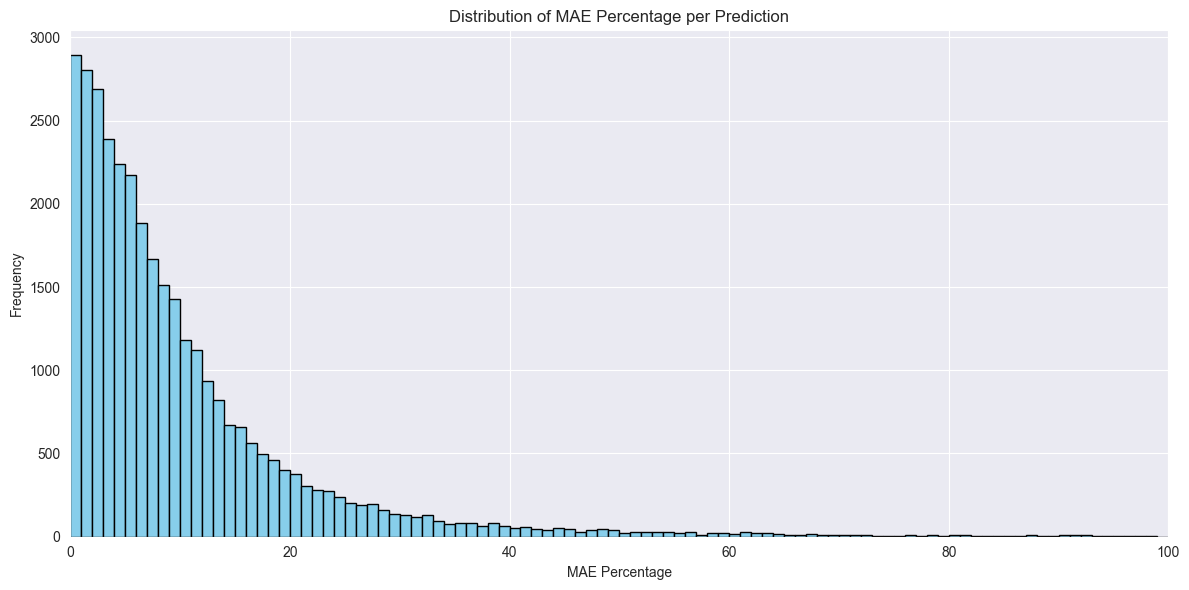

In [144]:
mae_percent = predicted_df['error_pct']
# Create bins for each integer percentage from 0 to 100
bins = np.arange(0, 101, 1)  # from 0 to 100 with step of 1

plt.figure(figsize=(12, 6))
plt.hist(mae_percent, bins=bins, color='skyblue', edgecolor='black')

plt.xlabel("MAE Percentage")
plt.ylabel("Frequency")
plt.title("Distribution of MAE Percentage per Prediction")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

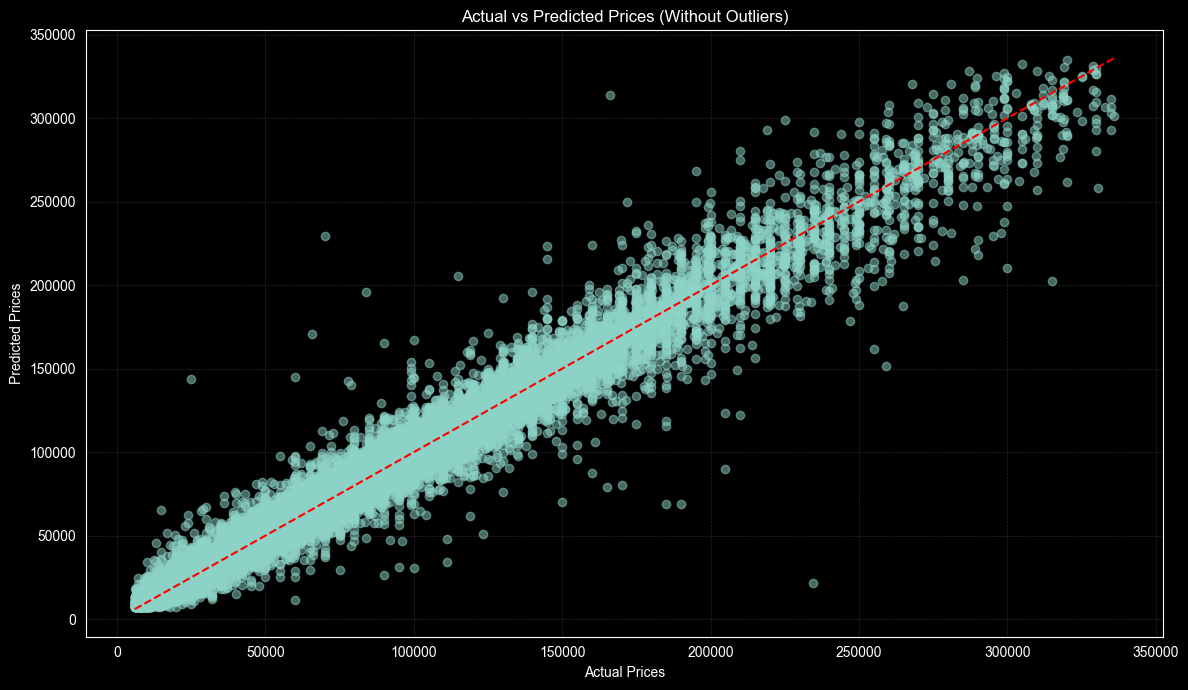

In [146]:
# Convert to numpy arrays if needed
y_test_np = np.array(boots_df_gbm['price'])
y_pred_np = np.array(boots_df_gbm['predicted_price'])

# Remove outliers using percentiles
lower_percentile = 1
upper_percentile = 99
mask = (
    (y_test_np >= np.percentile(y_test_np, lower_percentile)) & 
    (y_test_np <= np.percentile(y_test_np, upper_percentile)) & 
    (y_pred_np >= np.percentile(y_pred_np, lower_percentile)) & 
    (y_pred_np <= np.percentile(y_pred_np, upper_percentile))
)

y_test_filtered = y_test_np[mask]
y_pred_filtered = y_pred_np[mask]

# Plot
plt.figure(figsize=(12, 7))
plt.style.use("dark_background")
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)

# Line of perfect prediction
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 'r--')

# Axes labels and title
plt.xlabel("Actual Prices", color='white')
plt.ylabel("Predicted Prices", color='white')
plt.title("Actual vs Predicted Prices (Without Outliers)", color='white')

# Customize tick and spine colors
plt.tick_params(colors='white')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('white')

plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()

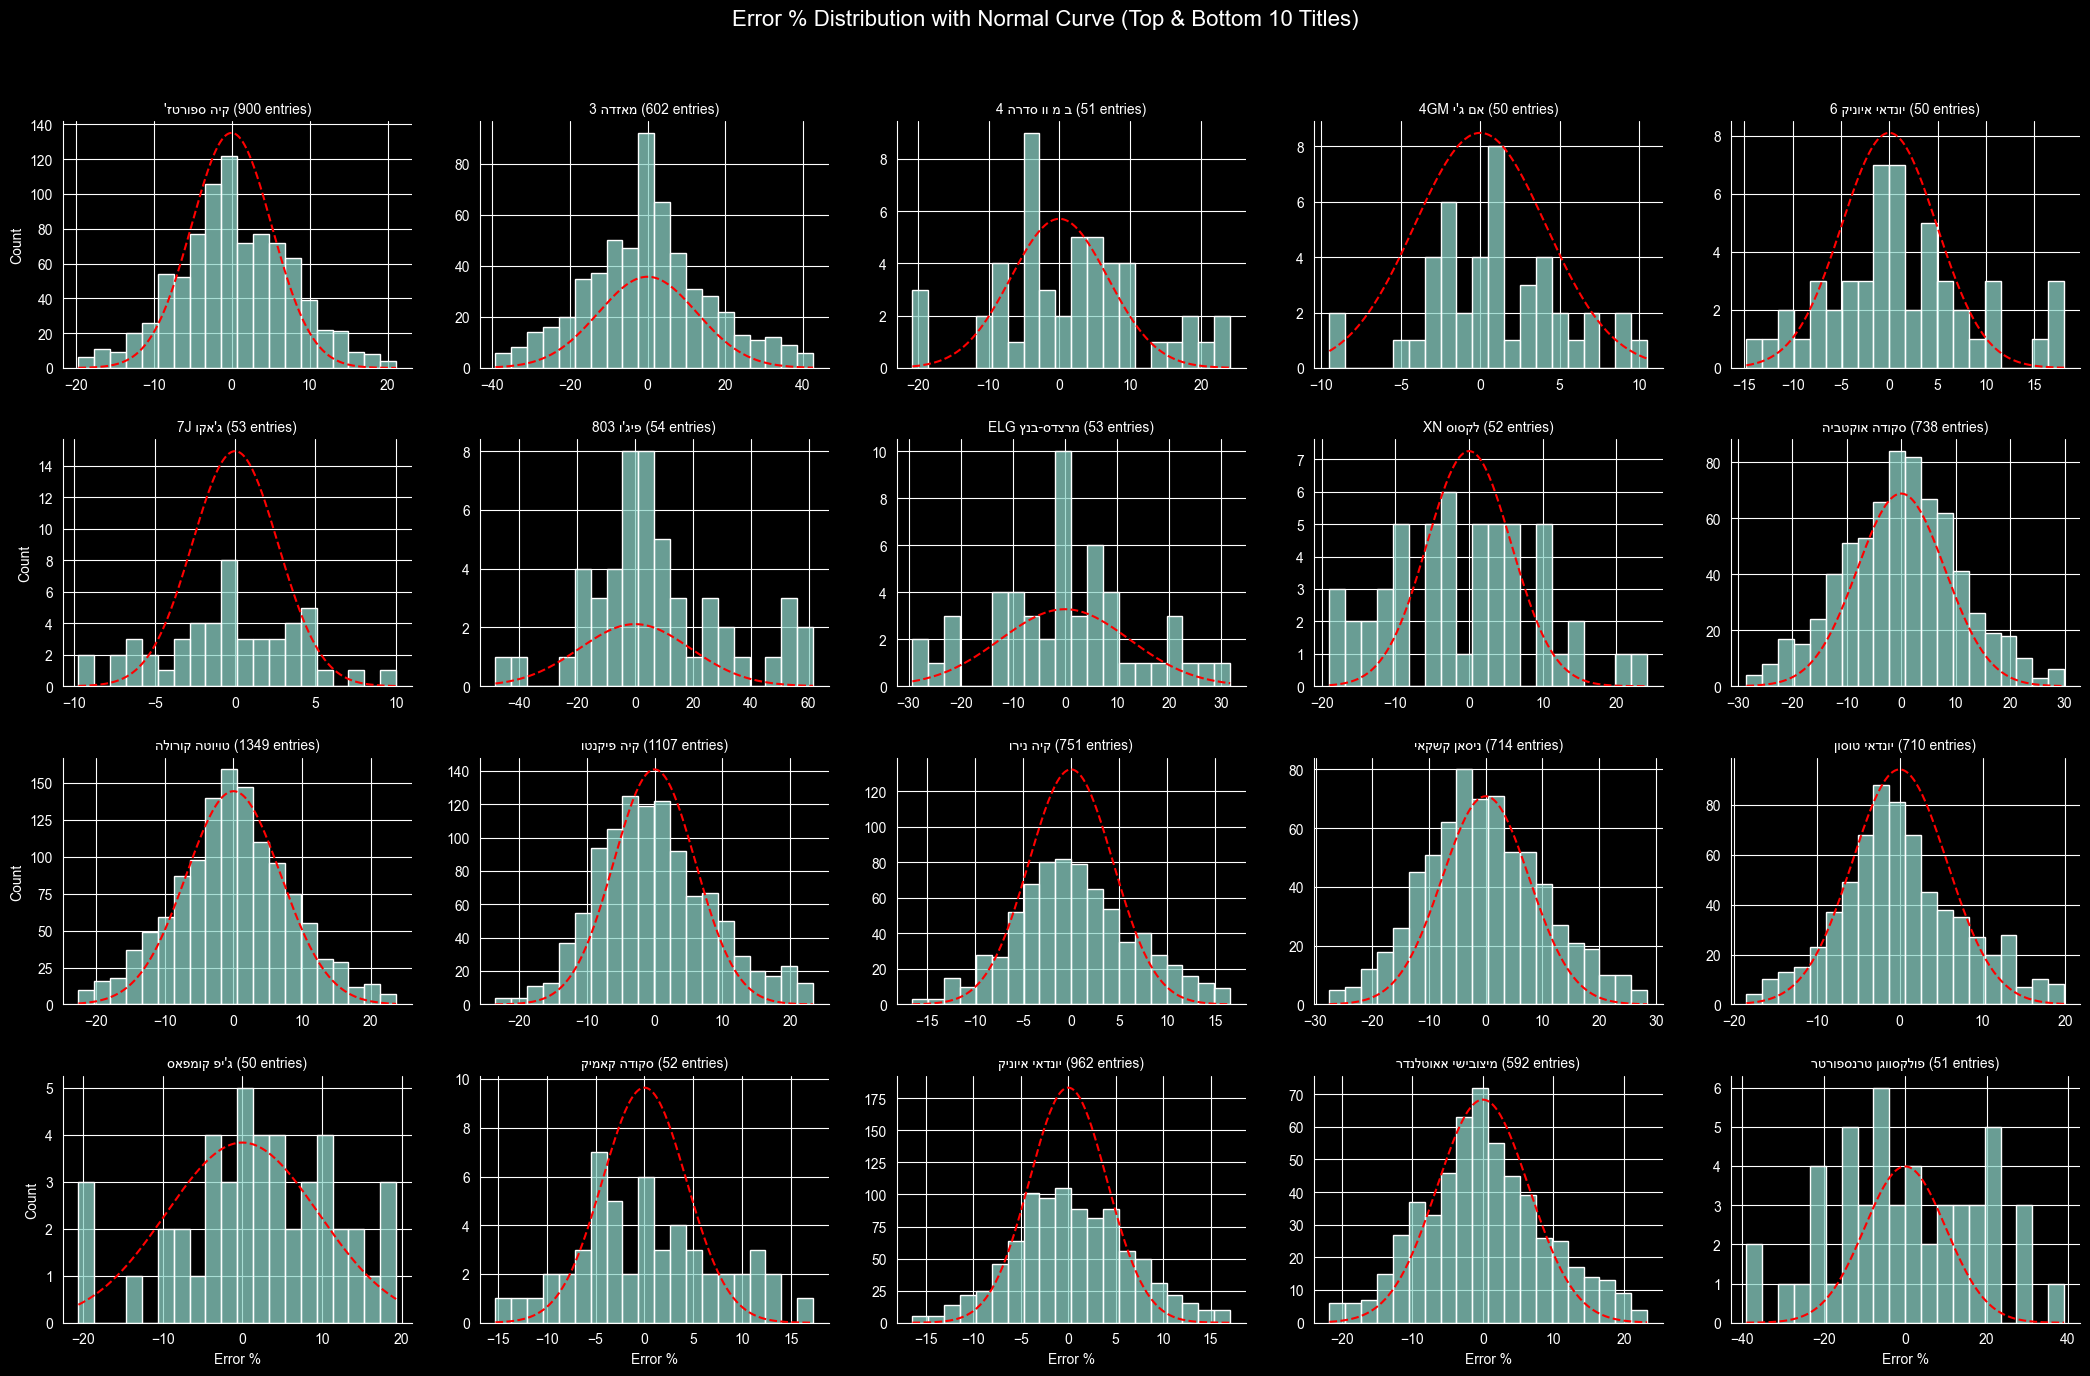

In [147]:
# Step 1: Count entries per title
title_counts = predicted_df['title'].value_counts()

# Step 2: Get top 10 and bottom 10 titles
top_10_titles = title_counts.head(10).index
bottom_10_titles = title_counts.tail(10).index

# Step 3: Prepare function to reverse titles and add metadata
def prepare_df(df, titles, label):
    filtered = df[df['title'].isin(titles)].copy()
    filtered['title_with_count'] = filtered['title'].apply(
        lambda t: f"{t[::-1]} ({title_counts[t]} entries)"
    )
    filtered['group'] = label
    return filtered

top_df = prepare_df(predicted_df, top_10_titles, "Top 10")
bottom_df = prepare_df(predicted_df, bottom_10_titles, "Bottom 10")
combined_df = pd.concat([top_df, bottom_df])

# Step 4: Remove outliers per title using IQR method
def remove_outliers_iqr(df, col='error_pct_not_abs'):
    cleaned_list = []
    for name, group in df.groupby('title_with_count'):
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        cleaned = group[(group[col] >= lower) & (group[col] <= upper)]
        cleaned_list.append(cleaned)
    return pd.concat(cleaned_list)

filtered_df = remove_outliers_iqr(combined_df)

# Step 5: Merge std_error_pct from title_errors
title_errors_filtered['title_with_count'] = title_errors_filtered['title'].apply(
    lambda t: f"{t[::-1]} ({title_counts.get(t, 0)} entries)"
)
filtered_df = filtered_df.merge(
    title_errors_filtered[['title_with_count', 'std_error_pct']],
    on='title_with_count',
    how='left'
)

# Step 6: Plot error distribution + normal curve
def plot_hist_with_normal(data, color, **kwargs):
    sns.histplot(data['error_pct_not_abs'], bins=20, color=color, stat="count")
    
    std = data['std_error_pct'].iloc[0]
    mean = 0  # assuming centered error distribution
    x_vals = np.linspace(data['error_pct_not_abs'].min(), data['error_pct_not_abs'].max(), 200)
    y_vals = norm.pdf(x_vals, loc=mean, scale=std) * len(data) * 2  # scale to match histogram
    
    plt.plot(x_vals, y_vals, 'r--', label='Normal (std)')
    plt.legend()

g = sns.FacetGrid(
    filtered_df,
    col="title_with_count",
    col_wrap=5,
    sharex=False,
    sharey=False,
    height=3.5,
    aspect=1.2
)
g.map_dataframe(plot_hist_with_normal)
g.set_axis_labels("Error %", "Count")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Error % Distribution with Normal Curve (Top & Bottom 10 Titles)", fontsize=16)

plt.show()


In [148]:
# Step 1: Compute title-level aggregates on full dataset
title_aggregates = process_df.groupby('title').agg({
    'price': 'mean',
    'mileage': 'mean',
    'months_on_road': 'mean'
}).rename(columns={
    'price': 'avg_price_by_title',
    'mileage': 'avg_mileage_by_title',
    'months_on_road': 'avg_months_on_road_by_title'
}).reset_index()

# Step 2: Merge title aggregates into full dataset
df = process_df.merge(title_aggregates, on='title', how='left')

# Step 3: Feature engineering
df['mileage_vs_avg_title'] = df['mileage'] / df['avg_mileage_by_title']
df['months_vs_avg'] = df['months_on_road'] / df['avg_months_on_road_by_title']

# Step 4: Prepare training data
exclude = ['listing_id', 'title', 'price', 'predicted_price', 'url',
           'scrape_date', 'upload_date', 'test_date', 'on_road_date']
features = [col for col in df.columns if col not in exclude]
X = df[features].copy()
y = df['price'].copy()

# Step 5: Replace infs and NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 6: Convert object columns to category
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Step 7: Detect column types
cat_features = X.select_dtypes(include='category').columns.tolist()
num_features = X.select_dtypes(include='number').columns.tolist()

# Step 8: Build imputation pipeline
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_features),
    ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
])

# Step 9: Impute missing values
X_imputed = pd.DataFrame(preprocessor.fit_transform(X))
X_imputed.columns = (num_features + cat_features)[:X_imputed.shape[1]]

# Coerce numeric columns to float
for col in num_features:
    X_imputed[col] = pd.to_numeric(X_imputed[col], errors='coerce')

for col in cat_features:
    X_imputed[col] = X_imputed[col].astype('category')

# Step 10: Encode categoricals
encoder = OrdinalEncoder()
X_imputed[cat_features] = encoder.fit_transform(X_imputed[cat_features])

# Step 11: Train LightGBM model
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    random_state=42,
    verbosity=-1
)
model.fit(X_imputed, y)



# Step 12: Save model and preprocessing components
joblib.dump(model, "final_lgbm_model.pkl")
joblib.dump((preprocessor, encoder, features, num_features, cat_features), "lgbm_preprocessor.joblib")

print("✅ LightGBM model and preprocessing pipeline saved.")


✅ LightGBM model and preprocessing pipeline saved.


In [149]:
title_aggregates = title_aggregates.merge(title_errors_filtered[['title','std_error_pct']], on='title', how='inner')
title_aggregates.to_csv("title_aggregates.csv", index=False)